<a href="https://colab.research.google.com/github/Ranjani94/Deep_Learning/blob/master/Assignment2/Autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Simple Autograd Example

A simple automatic differentiation example ..


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Deep_Learning/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [0]:
class Tensor:

    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.requires_grad = requires_grad
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

In [0]:
class arithmetic_operation:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

In [0]:
class Addition_operation(arithmetic_operation):
    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

In [0]:
class Multiplication_operation(arithmetic_operation):
    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()


In [12]:
x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = Tensor(x,requires_grad=True)
_a = Tensor(a,requires_grad=True)
_b = Tensor(b,requires_grad=True)

# here we use parameter _a 2 times in different operations.
# that means that gradient will be calculated twice for _a.
# and thus we need to sum two gradients to get result 
# gradient for _a
y = Multiplication_operation()(
        Addition_operation()(
            Multiplication_operation()(
                _x, _a
            ), _b
        ), _a
    )
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(Tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  Tensor([[3.57447707e-01 3.33685967e-02 9.97873597e-01]
 [9.89845791e-03 2.28181938e-01 2.68874817e-02]
 [8.04799907e-01 5.26931489e-02 3.32303921e-04]])

y.grad_fn =  <__main__.Multiplication_operation object at 0x7fdb28ba7c50>

_x.grad =  Tensor([[2.85998720e-01 7.87070550e-02 7.62230809e-01]
 [1.29122343e-03 3.47244859e-01 2.94186276e-05]
 [4.30077581e-01 3.35114504e-02 2.26453689e-07]])

_a.grad =  Tensor([[0.71816576 0.16373993 1.48604766]
 [0.20951838 0.20431129 0.00308101]
 [0.82421379 0.11324591 0.08236984]])

_b.grad =  Tensor([[0.96787876 0.79128661 0.80313318]])

y.grad =  None


###Using Pytorch

In [13]:
_x = torch.tensor(x,requires_grad=True)
_a = torch.tensor(a,requires_grad=True)
_b = torch.tensor(b,requires_grad=True)
y = (_a*_x + _b) * _a
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(torch.tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)


y =  tensor([[3.5745e-01, 3.3369e-02, 9.9787e-01],
        [9.8985e-03, 2.2818e-01, 2.6887e-02],
        [8.0480e-01, 5.2693e-02, 3.3230e-04]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

y.grad_fn =  <MulBackward0 object at 0x7fdb28bf32e8>

_x.grad =  tensor([[2.8600e-01, 7.8707e-02, 7.6223e-01],
        [1.2912e-03, 3.4724e-01, 2.9419e-05],
        [4.3008e-01, 3.3511e-02, 2.2645e-07]], dtype=torch.float64)

_a.grad =  tensor([[0.7182, 0.1637, 1.4860],
        [0.2095, 0.2043, 0.0031],
        [0.8242, 0.1132, 0.0824]], dtype=torch.float64)

_b.grad =  tensor([0.9679, 0.7913, 0.8031], dtype=torch.float64)

y.grad =  None


###Classification of MNIST dataset using pytorch

In [0]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input


        

In [15]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')
            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
2.7769362607536077
---------
208.4684792764321
---------
201.9119708303304
---------
178.76328025205203
---------
202.4605426792425
---------
192.39087096328717
---------
157.05659464576817
---------
166.5666738322124
---------
152.9484106598712
---------
146.34876312763578
---------
139.55362678015774
---------
131.3872911890213
---------
133.88384904632244
---------
146.96462030574148
---------
107.90730252069083
---------
111.87837832941386
---------
118.55877160056279
---------
117.55141123062603
---------
107.61546879066222
---------
97.54090050415178
---------
99.65749038017451
---------
98.43733852220285
---------
95.31748024048245
---------
89.44641570635503
---------
93.1643825692549
---------
75.52961337400954
---------
97.16547601780636
---------
80.14753213055023
---------
78.18259780893513
---------
86.29318632674412
---------
80.93999761918491
---------
69.03433911743814
------

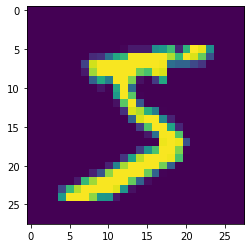

target: 5 predicted: 5


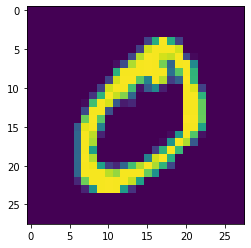

target: 0 predicted: 0


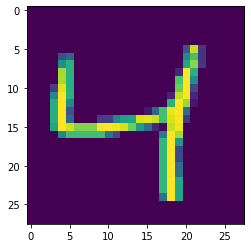

target: 4 predicted: 4


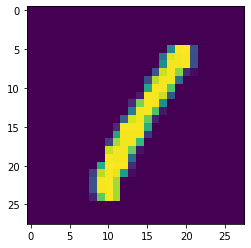

target: 1 predicted: 1


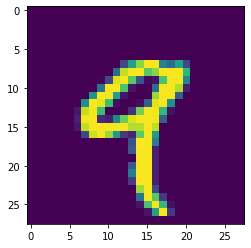

target: 9 predicted: 9


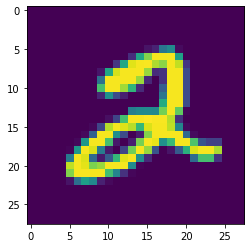

target: 2 predicted: 0


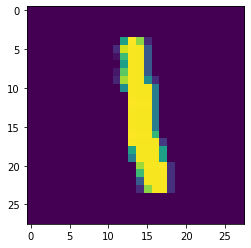

target: 1 predicted: 1


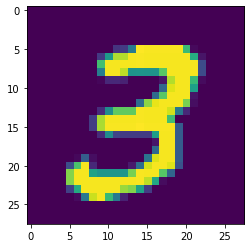

target: 3 predicted: 3


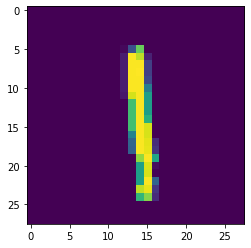

target: 1 predicted: 1


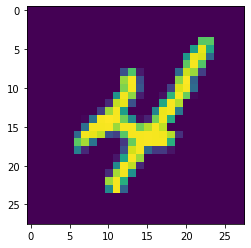

target: 4 predicted: 4


In [16]:
import matplotlib.pyplot as plt
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )

References: https://medium.com/@a.nikishaev/making-backpropagation-autograd-mnist-classifier-from-scratch-in-python-bec4f05ce09f

https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html
https://github.com/dlsys-course/assignment1/blob/master/autodiff_test.py

https://www.kaggle.com/borisettinger/gentle-introduction-to-automatic-differentiation

http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/tutorials/tut4.pdf